# Overview

Shor's algorithm is used for finding the prime factors of an integer. In this notebook we will denote $N$ as the integer to-be-factored, and $p$,$q$ as the prime factors of $N$ (i.e., $N = p \cdot q$).

The pseudocode for Shor's algorithm is outlined below.

$\newcommand{\if}[1]{{\textbf{if }{#1}\textbf{ then:}}}$
$\newcommand{\else}{{\textbf{else:}}}$

---
**Algorithm Shor**

**Input:** An integer $N$

**Output:** $p,q$ such that $N=p \cdot q$

**begin**

```
Choose a random integer 1 < a < N
b := gcd(a,N)
if b != 1:
    b factors N so return (p, q) = (b, N/b)
else:
    Use quantum subroutine to find the order r of a
    if r is odd:
        go to line 1
    g := gcd(a^(r/2) +/- 1, N)
    if g > 1:
        return (p, q) = (g, N/g)
    else:
        go to line 1
```

**end**

---

Which seems trivial enough - the hard part of this is implementing the quantum subroutine. Before we the specific details of this routine, some concepts should be to be gone over.

## Qubits

Similar to how a CPU stores information in the form of bits, a quantum processing unit (QPU) stores information in the form of **qubits**. The difference between the two is that a bit is always in the state of either $0$ or $1$, a qubit $\psi$ exists as a *superposition* of these states at one time, since it is a quantum state.

$$
\ket{\psi} = \alpha \ket{0} + \beta \ket{1}
$$

where $\alpha, \beta \in \mathbb{C}$ are probability amplitudes, so $|\alpha|^2 + |\beta|^2 = 1$.

With one state, there isn't much you can do. Combining a bunch of states together is where we can make calculations that are more efficient than they would be on a CPU. We hold a number of qubits in quantum registers.

## Quantum Registers

We store a set of qubits in the form of **quantum registers** - so a quantum register of size $n$ is a quantum system composed of $n$ qubits. Just like in the case of bits, an $n$-size register can contain (decimal) values up to $2^n - 1$. 

In this notebook we will be using [Qiskit](https://www.ibm.com/quantum/qiskit), where initializing a quantum register creates a set of qubits in the state $\ket{0}$, i.e.,

$$
\ket{\psi} = \ket{0}^{\otimes n} = \ket{0} \ket{0} \cdots \ket{0} = \ket{00 \cdots 0} = \ket{0}
$$

Note:
- We use $\otimes n$ to denote a register being of size $n$.
- Writing $\ket{0}$ is equivalent to writing $\ket{00 \cdots 0}$ (just as $\ket{1}$ is equivalent to writing $\ket{00 \cdots 1}$, $\ket{2}$ as $\ket{00 \cdots 10}$ and so on).

We manipulate the set of states we have via quantum gates.

## Quantum Gates

A **quantum gate** is what allows us to manipulate a quantum register and its qubits. A commonly used example is the Hadamard gate $H$, which can act on a single qubit to transform it into an equally-distributed superposition of any of its $2^n$ possible states. This is useful when we have a quantum register initialized in the state $\ket{0}$, where we can apply a Hadamard gate to create a superposition of all possible states.

$$
\ket{\psi'} = H \left( \ket{0}^{\otimes n} \right) = 2^{-n/2} \left( \ket{0} + \ket{1} + \cdots + \ket{2^n - 1} \right) = 2^{-n/2} \sum_{k=0}^{2^n-1} \ket{k}
$$

Chanining a bunch of these together allows us to put the register into a state where we can make a **measurement**. The math is important here, because we can deduce what we are measuring and the probability of measuring that value. For example, if we were to make a measurement on $\ket{\psi'}$ we would get some $k_0 \in [0, 2^{n}-1]$ with probability

$$
\mathcal{P}_{k_0} = |\braket{k_0 | \psi'}|^2 = 2^{-n} |\braket{k_0 | k_0}|^2 = 2^{-n}
$$

In this example it is equally likely to measure any $k_0$. The sum in $\ket{\psi'}$ disappears (or "collapses") due to the fact that qubit states are *orthonormal*, i.e.,

$$
\braket{k_0 | k} = \delta_{k_0, k}
$$

where $\delta_{k_0, k}$ is the Kronecker delta, which is 0 if $k_0 \neq k$ and otherwise 1. This is the only way for us to get information from a qubit - once we make a measurement on the qubit, the qubit will collapse to the state of the value we measured (e.g., $\sum_{k=0}^{2^n-1} \ket{k}$ collapses to $\ket{k_0}$).

## Quantum Circuits

A **quantum circuit** is a way to model quantum computation (analogous to classical circuits). It is made up of initializing qubits, applying quantum gates, and making measurements (in no particular order). It is a way for us to build and visualize the operations of our quantum computations.

For example, we can build a quantum circuit to apply a Hadamard gate and make a measurement

In [7]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# size of register
n = 5

# create registers
qr = QuantumRegister(n, name='q')
cr = ClassicalRegister(n, name='c')

# create circuit composing of registers
qc = QuantumCircuit(qr, cr)

# apply Hadamard gate
qc.h(qr)

qc.measure(qr, cr)

qc.draw(fold=-1)

┌───┐┌─┐            
q_0: ┤ H ├┤M├────────────
     ├───┤└╥┘┌─┐         
q_1: ┤ H ├─╫─┤M├─────────
     ├───┤ ║ └╥┘┌─┐      
q_2: ┤ H ├─╫──╫─┤M├──────
     ├───┤ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├─╫──╫──╫─┤M├───
     ├───┤ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├─╫──╫──╫──╫─┤M├
     └───┘ ║  ║  ║  ║ └╥┘
c: 5/══════╩══╩══╩══╩══╩═
           0  1  2  3  4

## Modulo Circuit

Here we look to construct a circuit that does the operation

$$
\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N}
$$

For coprime integers $a,N$. Since both are integers we can express $a = sN + d$ (e.g., $73 = 4(15) + 13$). Thus, if we are able to find $s$, then we can compute $d = a \bmod N = a - sN$.

Consider two quantum registers $\ket{N}^{\otimes n}$ and $\ket{a}^{\otimes m}$ where we restrict $m>n$.

We know that $s \in [0, 2^{m-n+1} - 1]$, so we can use a binary search to find the correct value of $s$. The key idea is to continuously shrink the interval based on the comparison between $(s_{0}N, a)$, where $s_{0}$ is the midpoint of the current interval. When the interval is no longer larger than 1, we know that $s=s_{0}$.

The pseudocode for this algorithm/circuit is described below, along with a table of each registers purpose.

| Register                | Purpose                                                         | Size    |
| ----------------------- | --------------------------------------------------------------- | ------- |
| $\ket{N}_{N}$           | Storing input $N$                                               | $n$     |
| $\ket{a}_{a}$           | Storing input $a$                                               | $m$     |
| $\ket{0}_{m}$           | Storing the midpoint $s_{0}$                                    | $m-n+1$ |
| $\ket{0}_{s}$           | Storing the result of $s_{0}N$                                  | $m$     |
| $\ket{0}_{l}$           | Storing the beginning of the current interval                   | $m-n+1$ |
| $\ket{2^{m-n+1}-1}_{r}$ | Storing the end of the current interval                         | $m-n+1$ |
| $\ket{0}_{c}$           | Control register/qubit for result of comparing $(s_{0}N,a)$     | $1$     |
| $\ket{1}_{f}$           | Control register/qubit for storing if the interval size is $>1$ | $1$     |
| $\ket{0}_{R}$           | Storing the result $a \bmod N$                                  | $m$     |

0. Initialize registers (for convenience we will omit explicitly writing the interval endpoints, with $l=0$ and $r=2^{m-n+1}-1$). $$
\ket{\Psi_0} = \ket{N}^{\otimes n}_N \ket{a}^{\otimes m}_a \ket{0}^{\otimes m-n+1}_m \ket{0}^{\otimes m}_s \ket{l}^{\otimes m-n+1}_l \ket{r}^{\otimes m-n+1}_r \ket{0}^{\otimes 1}_c \ket{1}_{f}
$$

1. Compute the midpoint ($s_{0} = \left\lfloor \frac{l+r}{2}  \right\rfloor$): $\ket{l}_l \ket{r}_r \ket{0}_m \to \ket{l}_l \ket{r}_r \ket{s_{0}}_m$
$$
\ket{\Psi_1} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

2. Flip $\ket{1}_{f} \to \ket{0}_{f} \iff r-l \leq 1$. Steps 3-9 are computed only if we have $\ket{1}_{f}$.
$$
\ket{\Psi_{2}} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

3. Compute $s_{0}N$: $\ket{N}_N \ket{s_{0}}_m \ket{0}_s \to \ket{N}_N \ket{s_{0}}_m \ket{s_{0} N}_s$
$$
\ket{\Psi_3} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{s_{0} N}_s \ket{l}_l \ket{r}_r \ket{0}_c \ket{1}_{f}
$$

4. Flip the control qubit: $\ket{0}_c \to \ket{1}_c \iff s_{0} N > a$
$$
\ket{\Psi_4} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{s_{0} N}_s \ket{l}_l \ket{r}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

5. Uncompute $\ket{s_{0}N}_{s}$: $\ket{N}_{N} \ket{s_{0}}_{m} \ket{s_{0}N}_{s} \to \ket{N}_{N} \ket{s_{0}}_{m} \ket{0}_{s}$
$$
\ket{\Psi_5} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l}_l \ket{r}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

6. Update the interval registers with the control qubit:
$$
\ket{0 \text{ or } 1}_c \ket{l}_l \ket{r}_r \to \ket{0 \text{ or } 1}_c \ket{l'}_{l} \ket{r'}_{r} =
\begin{cases}
    \ket{s_{0}}_l \ket{r}_r & \text{ if } \ket{0}_c \\
    \ket{l}_l \ket{s_{0}}_r & \text{ if } \ket{1}_c
\end{cases}
$$
$$
\ket{\Psi_6} = \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

7. Uncompute the midpoint register: $\ket{l'}_{l} \ket{r'}_{r} \ket{0 \text{ or } 1}_{c} \ket{s_{0}}_{m} \to \ket{l'}_{l} \ket{r'}_{r} \ket{0 \text{ or } 1}_{c} \ket{0}_{m}$
$$
\ket{\Psi_7} = \ket{N}_N \ket{a}_a \ket{0}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0 \text{ or } 1}_c \ket{1}_{f}
$$

8. Uncompute the control qubit:
$$
\ket{\Psi_8} = \ket{N}_N \ket{a}_a \ket{0}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{1}_{f}
$$

9. Go back to step 1

10. At this point $r'-l' \leq 1$, so then $s = s_0$.
    Perform: $\ket{N}_{N} \ket{s_{0}}_{m} \ket{0}_{R} \to \ket{N}_{N} \ket{s_{0}}_{m} \ket{s_{0}N}_{R}$ followed by $\ket{a}_{a}\ket{s_{0}N}_{R} \to \ket{a}_{a}\ket{a - s_{0}N}_{R}$
$$
\begin{align}
\ket{\Psi_9} &= \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{0}_{f} \ket{a - s_{0}N}_{R} \\
&= \ket{N}_N \ket{a}_a \ket{s_{0}}_m \ket{0}_s \ket{l'}_l \ket{r'}_r \ket{0}_c \ket{0}_{f} \ket{a \bmod N}_{R}
\end{align}
$$


Before implementing the modulo circuit we will write some helper functions to make life easier.

In [8]:
import math

def bits_required(n: int) -> int:
    return int( math.log(n,2) + 1 ) if n > 0 else 0

def int_to_bits(n: int, num_bits: int = None) -> list:
    nbits = bits_required(n)
    if num_bits != None: nbits = num_bits

    return [(n >> bit) & 1 for bit in range(nbits - 1, -1, -1)]    

def init_register(circ, q_reg, value: int):
    qr_size = len(q_reg)
    bits = int_to_bits(value)[::-1]

    if qr_size < len(bits):
        raise ValueError(f'number of bits required is larger than size of register ({qr_size} < {len(bits)})')
    
    for i,bit in enumerate(bits):
        if bit == 1:
            circ.x(q_reg[i])

def DivBy2Gate(n_qbits):
    # just shift bits to right
    # start on right and swap with left until end
    # make last qubit |0⟩

    q_reg = QuantumRegister(n_qbits)
    circ = QuantumCircuit(q_reg)

    for i in range(n_qbits-1):
        circ.swap(q_reg[i], q_reg[i+1])

    circ.reset(q_reg[-1])
    
    return circ.to_instruction(label='Divide by 2')


In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, AncillaRegister, QuantumRegister
from qiskit.circuit.library import HalfAdderGate, SwapGate, IntegerComparator, MultiplierGate

def q_amodN(a, N):

    a_bits = bits_required(a)
    n = bits_required(N)
        
    m = max(2*n, a_bits)
    mn1 = m - n + 1
    print(f'n = {n}, m = {m}, |m-n| + 1 = {mn1}')
    
    # create registers
    qr_N = QuantumRegister(mn1+1,       name='N')
    qr_a = QuantumRegister(m,           name='a')
    qr_m = QuantumRegister(mn1+1,       name='m')
    qr_s = QuantumRegister(2*(mn1+1),   name='s')
    qr_l = QuantumRegister(mn1,         name='l')
    qr_r = QuantumRegister(mn1,         name='r')
    qr_c = QuantumRegister(1,           name='c')
    qr_f = QuantumRegister(1,           name='f')
    qr_R = QuantumRegister(2*(mn1+1),   name='R')
    qr_rl = QuantumRegister(mn1+1,      name='r-l')
    ar_c = AncillaRegister(2*(mn1+1)-1, name='ac')  # required for IntegerComparator
    ar_f = AncillaRegister(mn1,         name='af')  # required for IntegerComparator
    cr_f = ClassicalRegister(1, name='cf')

    circ = QuantumCircuit(qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl, ar_c, ar_f, cr_f)

    # initialize registers
    # ====================================================
    init_register(circ, qr_N, N)
    init_register(circ, qr_a, a)
    init_register(circ, qr_r, 2**mn1 - 1)
    init_register(circ, qr_f, 1)

    circ.barrier()
    
    # compute midpoint into qr_m
    # ===========================================
    add_gate = HalfAdderGate(mn1)
    circ.append(add_gate, qr_l[:] + qr_m[:])
    circ.append(add_gate, qr_r[:] + qr_m[:])

    div2_gate = DivBy2Gate(len(qr_m))
    circ.append(div2_gate, qr_m[:])

    circ.barrier()
    
    # compare interval and update qr_f accordingly
    # ====================================================
    # put r-l into qr_rl
    circ.append(add_gate, qr_r[:] + qr_rl[:])
    sub_gate = add_gate.inverse()
    circ.append(sub_gate, qr_l[:] + qr_rl[:])
    
    compare_gate = IntegerComparator(num_state_qubits=mn1+1, value=2, geq=False, name='compare < 2')
    circ.append(compare_gate, qr_rl[:] + qr_f[:] + ar_f[:])

    circ.barrier()

    circ.measure(qr_f[:], cr_f[:])
    
    # compute the rest iff qr_f == |1⟩
    # ====================================================
    # ----------------------------------------------------
    with circ.while_loop((cr_f[0], 1)):

        # compute s0 * N
        mult_gate = MultiplierGate(num_state_qubits=mn1+1,label='s0 * N')
        circ.append(mult_gate, qr_N[:] + qr_m[:] + qr_s[:])
    
        circ.barrier()

        # comparing s0 * N > a
        compare_gate = IntegerComparator(num_state_qubits=2*(mn1+1), value=a, name='compare s0 * N > a')
        circ.append(compare_gate, qr_s[:] + qr_c[:] + ar_c[:])
    
        circ.barrier()

        # uncomputing s0 * N
        imult_gate = mult_gate.inverse()
        imult_gate.name = 'uncompute s0 * N'
        circ.append(imult_gate, qr_N[:] + qr_m[:] + qr_s[:])

        # if control qubit |c⟩ == |0⟩
        circ.measure(qr_c[:], cr_c[:])
        with circ.if_test((cr_c, 0)) as else_:
            # update |l⟩ -> |s0⟩

            # uncompute midpoint |l⟩|s0⟩ -> |l⟩|0⟩
            pass
            
        # if control qubit |c⟩ == |1⟩
        with else_: 
            # update |r⟩ -> |s0⟩

            # uncompute midpoint |r⟩|s0⟩ -> |r⟩|0⟩
            pass
    
    # ----------------------------------------------------

    circ.barrier()
    
    circ.append(mult_gate, qr_N[:] + qr_m[:] + qr_s[:])
    
    sub_gate = HalfAdderGate(m, label='a - s0 * N').inverse()
    circ.append(sub_gate, qr_s[:len(qr_a)+1] + qr_a[:])
    
    #print(circ.draw(fold=-1))

    return circ#.to_instruction(label='a mod N')


q_amodN(7, 41).draw(fold=-1)
    

n = 6, m = 12, |m-n| + 1 = 7


NameError: name 'cr_c' is not defined

## Modular Exponentiation Circuit

Now that we are able to perform the operation $\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N}$, we can use a combination of this and SWAP gates to perform modular exponentiation, i.e.,

$$
\ket{N} \ket{a} \ket{0} \to \ket{N} \ket{a} \ket{a^x \bmod N}
$$

We will use the identity

$$
a^x \bmod N = a ( \cdots a (a \bmod N) \bmod N \cdots ) \bmod N
$$

So the general process will accept integers $a,N,x$ and will look something like:

1. Initialize four registers $\ket{N}^{\otimes n} \ket{a}^{\otimes m} \ket{0} \ket{0}^{\otimes m}$

2. Apply the Modulo circuit/gate $\ket{N} \ket{a} \ket{0} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N} \ket{0}$

3. $\ket{N} \ket{a} \ket{a \bmod N} \ket{0} \to \ket{N} \ket{a} \ket{a \bmod N} \ket{a (a \bmod N)}$

4. $\ket{N} \ket{a} \ket{a \bmod N} \ket{0} \to \ket{N} \ket{a} \ket{0} \ket{a (a \bmod N)}$

5. $\ket{N} \ket{a} \ket{0} \ket{a (a \bmod N)} \to \ket{N} \ket{a (a \bmod N)} \ket{0} \ket{a}$

6. $\ket{N} \ket{a (a \bmod N)} \ket{0} \ket{a} \to \ket{N} \ket{a (a \bmod N)} \ket{0} \ket{0}$

7. Go back to step 2 and repeat $x-1$ times

In [10]:

def BuildModExpCircuit(a, N, x):

    a_bits = bits_required(a)
    
    n = bits_required(N)
    m = max(2*n, a_bits)
    mn1 = abs(m - n) + 1

    # create registers
    qr_N = QuantumRegister(n,   name='N')
    qr_a = QuantumRegister(m,   name='a')
    qr_m = QuantumRegister(mn1+1, name='m')
    qr_s = QuantumRegister(m,   name='s')
    qr_l = QuantumRegister(mn1, name='l')
    qr_r = QuantumRegister(mn1, name='r')
    qr_c = QuantumRegister(1,   name='c')
    qr_f = QuantumRegister(1,   name='f')
    qr_R = QuantumRegister(m,   name='R')
    qr_rl = QuantumRegister(mn1+1, name='r-l')

    circ = QuantumCircuit(qr_N, qr_a, qr_m, qr_s, qr_l, qr_r, qr_c, qr_f, qr_R, qr_rl)

    circ.append(q_amodN(a, N), qr_N[:] + qr_a[:] + qr_m[:] + qr_s[:] + qr_l[:] + qr_r[:] + qr_c[:] + qr_f[:] + qr_R[:] + qr_rl[:])
    
        
    return circ

circ = BuildModExpCircuit(7, 15, 3)
#circ.draw(fold=-1)

n = 4, m = 8, |m-n| + 1 = 5


NameError: name 'cr_c' is not defined

## Optimizations

Before we get to the general implementation of order finding, we will implement some optimizations on the modular exponentiation circuit for special cases of $a,N$

One example of how the optimizations work will be shown for $a=2, N=15$. Recall we are doing the transformation $\ket{x}\ket{1} \to \ket{x}\ket{a^x \bmod N}$.

Expanding the sum of the expected state lets us identify:

$$
\begin{align}
\sum_{l=0}^{2^n - 1} \ket{l} \ket{a^l \bmod N} &= \ket{0} \ket{1} + \ket{1} \ket{2} + \ket{2} \ket{4} + \ket{3} \ket{8} + \cdots \\
&= \ket{0}\ket{0001} + \ket{1}\ket{0010} + \ket{2}\ket{0100} + \ket{3}\ket{1000} \\
& \ + \ket{4}\ket{0001} + \ket{5}\ket{0010} + \ket{6}\ket{0100} + \ket{7}\ket{1000} + \cdots
\end{align}
$$

We can see that to apply the modular exponentiation in this case, we can just take each (initial) state $\ket{l} \ket{1}$ and just swap each qubit with its neighbour $l$ times.

In [43]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    As = [2,4,7,8,11,13]
    if a not in As:
        raise ValueError(f"'a' must be in {As}")
    U = QuantumCircuit(4)
    for _ in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)

    U = U.to_gate(label=f"{a}^{power} mod 15")
    return U.control()

def c_amod21(a, power):
    """Controlled multiplication by a mod 27"""
    As = [4]
    if a not in As:
        raise ValueError(f"'a' must be in {As}")
    U = QuantumCircuit(5)
    for _ in range(power):
        if a in [4]:
            U.swap(0,2)
            U.swap(0,4)

    U = U.to_gate(label=f"{a}^{power} mod 21")
    return U.control()
        
# function to get the optimized gate for (a,N) if there is an available one
# returns None if none are available
def opt_amodN(a, N, x=1):
    try:
        if N == 15:
            return c_amod15(a, x)
        elif N == 21:
            return c_amod21(a, x)
    except ValueError as verr:
        print(verr)
        return None

## Order Finding Circuit

Now that we have the ability to apply modular exponentiation, we can examine the full quantum order finding subroutine.

---
**Quantum Order Finding Subroutine**

**Input:** coprime integers $N$ and $1 < a < N$

**Output:** order of $a$, i.e., $\min r > 0$ such that $a^r \equiv 1 \bmod N$

1. $m := \lfloor \lg{N} + 1 \rfloor$

   this is the number of bits required to store $N$

2. $n:=2m$

   $n$ is arbitrary - but a larger $n$ yields a more accurate result. $n=2m$ is commonly used.

3. Construct the initial state of registers $\ket{\Psi_{0}} = \ket{0}^{\otimes n} \ket{1}^{\otimes m}$

4. Apply a Hadamard gate to the first register to create a superposition of all values between $0$ and $2^n-1$
   $$
\ket{\Psi_{1}} = (H \otimes I) \ket{\Psi_{0}} = 2^{-n/2} \sum_{l=0}^{2^n - 1} \ket{l} \ket{1}  
$$

5. Apply the unitary operator $U\ket{y} = \ket{ay \bmod N} = e^{2\pi i \theta}\ket{y}$ to the second register. Repeatedly apply $U$ based on the value in $\ket{l}$.
   $$
\ket{\Psi_{2}} = 2^{-n/2} \sum_{l=0}^{2^n - 1}  \ket{l} U^l \ket{1} = 2^{-n/2} \sum_{l=0}^{2^n - 1} \ket{l} e^{2\pi i \theta l} \ket{1}  
$$

6. Apply the inverse quantum Fourier transform on the first register.
   $$
   \begin{align}
\ket{\Psi_{3}} = (QFT^{\dagger} \otimes I) \ket{\Psi_{2}} &= 2^{-n/2} \sum_{l=0}^{2^n - 1} e^{2 \pi i \theta l} \left( 2^{-n/2} \sum_{k=0}^{2^n - 1} e^{-2 \pi i kl/2^n} \ket{k}  \right) \ket{1}   \\
&= 2^{-n} \sum_{k,l=0}^{2^n - 1} e^{-2 \pi il (k - 2^n \theta) / 2^n} \ket{k} \ket{1}  \\
&= \sum_{k=0}^{2^n - 1} \left( 2^{-n} \sum_{l=0}^{2^n - 1} e^{-2 \pi i l (k - 2^n \theta)/2^n} \right) \ket{k} \ket{1} \\
&\equiv \sum_{k=0}^{2^n - 1} c_{k} \ket{k} \ket{1} 
\end{align}
$$

    where we define $c_{k} \equiv 2^{-n} \sum_{l=0}^{2^n - 1} e^{-2 \pi i l (k - 2^n \theta)/2^n}$.

7. Measure the first register in the computational basis. The possible outcomes are any of the ones in the superposition on the first register (i.e., $k=0,1,\dots,2^n-1$). The value we measure, $k_{0}$, will be of the form $k_{0} = 2^n \theta$. This is because the probability of getting some $k_{0}$ is
   $$
\mathcal{P}_{k_{0}} = \left| \bra{k_{0}}  \sum_{k=0}^{2^n - 1} c_{k} \ket{k} \right|^{2} = \left| c_{k_{0}} \right|^{2} = 2^{-2n}  \left| \sum_{l=0}^{2^n - 1} e^{-2 \pi i l (k_{0} - 2^n \theta)/2^n} \right|
$$

    which is maximized when $k_{0} = 2^n \theta$. Because of eigenvalues that the unitary operator $U$ produces, the phase $\theta$ is of the form $\theta = s/r$. Thus we can use continued fractions to extract the order $r$, from $k_{0}/2^n = s/r$.

---

In [44]:
from qiskit.circuit.library import QFT

def OrderFindingCircuit(a, N):

    opt_gate = opt_amodN(a, N)
    if opt_gate != None:

        m = bits_required(N)
        n = 2*m
        qr_0 = QuantumRegister(n, name='q0')
        qr_1 = QuantumRegister(m, name='q1')
        cr_r = ClassicalRegister(n)
        qc = QuantumCircuit(qr_0, qr_1, cr_r)

        for q in range(n):
            qc.h(q)

        qc.x(n)

        for q in range(n):
            opt_gate = opt_amodN(a, N, 2**q)
            qc.append(opt_gate, [q] + qr_1[:])

        iqft_gate = QFT(n, inverse=True)
        qc.append(iqft_gate, range(n))

        qc.measure(range(n), range(n))
        
        return qc


OrderFindingCircuit(4,21).draw(fold=-1)

┌───┐                                                                                                                                                               ┌───────┐┌─┐                           
 q0_0: ┤ H ├───────■───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0      ├┤M├───────────────────────────
       ├───┤       │                                                                                                                                                       │       │└╥┘┌─┐                        
 q0_1: ┤ H ├───────┼──────────────■────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤1      ├─╫─┤M├────────────────────────
       ├───┤       │              │                                                                                                                                        │       │ ║ └╥┘┌─┐                     
 q0_2: ┤ H ├───────┼──────────────┼──────────────■─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤2      ├─╫──╫─┤M├─────────────────────
       ├───┤       │              │              │                                                                                                                         │       │ ║  ║ └╥┘┌─┐                  
 q0_3: ┤ H ├───────┼──────────────┼──────────────┼──────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────┤3      ├─╫──╫──╫─┤M├──────────────────
       ├───┤       │              │              │              │                                                                                                          │       │ ║  ║  ║ └╥┘┌─┐               
 q0_4: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────■───────────────────────────────────────────────────────────────────────────────────────────┤4      ├─╫──╫──╫──╫─┤M├───────────────
       ├───┤       │              │              │              │              │                                                                                           │  IQFT │ ║  ║  ║  ║ └╥┘┌─┐            
 q0_5: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────■───────────────────────────────────────────────────────────────────────────┤5      ├─╫──╫──╫──╫──╫─┤M├────────────
       ├───┤       │              │              │              │              │               │                                                                           │       │ ║  ║  ║  ║  ║ └╥┘┌─┐         
 q0_6: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────■───────────────────────────────────────────────────────────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├─────────
       ├───┤       │              │              │              │              │               │               │                                                           │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q0_7: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────■──────────────────────────────────────────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────
       ├───┤       │              │              │              │              │               │               │                │                                          │       │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q0_8: ┤ H ├───────┼──────────────┼──────────────┼──────────────┼──────────────┼───────────────┼───────────────┼────────────────┼────────────────■─────────────────────────┤8      ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
       ├───┤       │              │              │              │              │               │               │                │                │                         │       │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─

The circuit looks as expected. Now we run the circuit through a simulator to see how it does.

## Simulating the Circuit

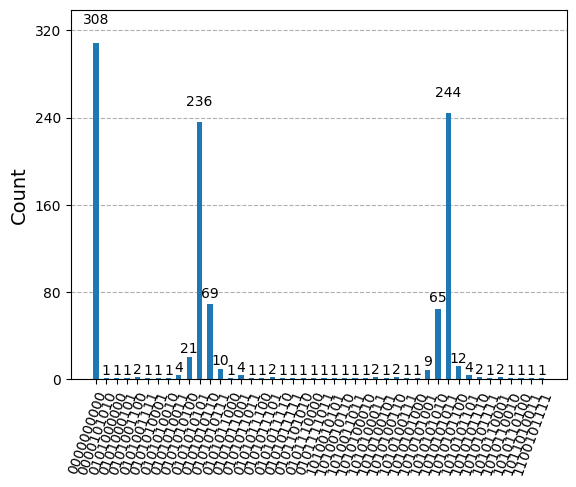

In [47]:
# Importing standard Qiskit libraries
from qiskit import transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import SwapGate

# set parameters and build circuit
a, N = 4,21
q_circ = OrderFindingCircuit(a, N)

# build simulator
simulator = Aer.get_backend("qasm_simulator")
circuit = transpile(q_circ, simulator)

# run simulator on circuit
result = simulator.run(circuit, memory=True).result()

# get counts and plot
counts = result.get_counts(circuit)
plot_histogram(counts)

The simulator works by running the circuit with a number of shots. We did not set a number, so the default of 1024 shots is used.

After each shot, the measurement stored in the classical register is stored. In the figure above we can see the distribution of how many times each result was produced.

In [56]:
n = 2 * bits_required(N)

for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n)  # Find corresponding eigenvalue

    frac = Fraction(phase).limit_denominator(N)
    print(f'{output}(bin) = {decimal:>3}(dec) has phase {decimal:>3}/{2**n} = {phase:.2f}  --->  r = {frac.denominator}')


0101011000(bin) = 344(dec) has phase 344/1024 = 0.34  --->  r = 3
0101011110(bin) = 350(dec) has phase 350/1024 = 0.34  --->  r = 20
0101011111(bin) = 351(dec) has phase 351/1024 = 0.34  --->  r = 20
0101111011(bin) = 379(dec) has phase 379/1024 = 0.37  --->  r = 19
1010100010(bin) = 674(dec) has phase 674/1024 = 0.66  --->  r = 20
1010010110(bin) = 662(dec) has phase 662/1024 = 0.65  --->  r = 17
0101011011(bin) = 347(dec) has phase 347/1024 = 0.34  --->  r = 3
1010110100(bin) = 692(dec) has phase 692/1024 = 0.68  --->  r = 19
0101011100(bin) = 348(dec) has phase 348/1024 = 0.34  --->  r = 3
0101000101(bin) = 325(dec) has phase 325/1024 = 0.32  --->  r = 19
0101011101(bin) = 349(dec) has phase 349/1024 = 0.34  --->  r = 3
0101001100(bin) = 332(dec) has phase 332/1024 = 0.32  --->  r = 19
0000101010(bin) =  42(dec) has phase  42/1024 = 0.04  --->  r = 21
0101001111(bin) = 335(dec) has phase 335/1024 = 0.33  --->  r = 3
1010101111(bin) = 687(dec) has phase 687/1024 = 0.67  --->  r = 3
1

We can see that most of the time, the correct order is found. But, this does not happen every time since we are using a probabilistic system. We will wrap this into a function that will try to find the order multiple times if the one it finds is not correct.

In [58]:
def qpe_amodN(a,N,writer=print):

    n = 2*bits_required(N)
    qc = OrderFindingCircuit(a,N)
    simulator = Aer.get_backend("qasm_simulator")
    circuit = transpile(q_circ, simulator)
    result = simulator.run(circuit, shots=1, memory=True).result()

    readings = result.get_memory()
    writer(f'Register reads: {readings[0]}')
    phase = int(readings[0], 2) / (2**n)
    writer(f'Phase: {phase}')
    return phase

In [59]:

def QOrderFinder(a, N, max_iter=10, debug=False):

    cout = print if debug else (lambda _: _)

    for attempt in range(1, max_iter+1):
        cout(f'\nattempt {attempt}...')

        phase = qpe_amodN(a,N, cout)
        frac = Fraction(phase).limit_denominator(N)
        r = frac.denominator
        cout(f'found order r = {r}')

        if phase != 0:
            guesses = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
            cout(f'guessed factors {guesses}')

            for guess in guesses:
                if guess in range(2,N) and (N % guess == 0):
                    cout(f'*** done: {guess} factors {N} ***')
                    return r

    # if no order could be found
    return 1

    
QOrderFinder(4,21, debug=True);


attempt 1...
Register reads: 0000000000
Phase: 0.0
found order r = 1

attempt 2...
Register reads: 0000000000
Phase: 0.0
found order r = 1

attempt 3...
Register reads: 1010101011
Phase: 0.6669921875
found order r = 3
guessed factors [3, 1]
*** done: 3 factors 21 ***


## Shor's Algorithm

Finally, we can implement Shor's algorithm (outlined at the beginning of this notebook).

In [62]:
import numpy as np

def shor(N: int, max_iter=10):

    def core(N):
        # choose random integer 1 < a < N
        a = np.random.randint(2, N)
    
        b = math.gcd(a, N)
    
        if b != 1:
            print(f'b = {b} factors {N}, returning ({b}, {N/b})')
            return (b, N//b)
    
        # quantum subroutine to find the order r of a
        r = QOrderFinder(a, N)
    
        # if r is odd
        if r % 2 != 0:
            # return None indicating to try algorithm again
            return None
    
        # we know one of these is a factor of N
        gs = [math.gcd(a**(r//2)-1, N), math.gcd(a**(r//2)+1, N)]
    
        for g in gs:
            if g > 1 and g < N:
                print(f'factor {g} found, returning ({g}, {N//g})')
                return (g, N/g)

            # return None indicating to try algorithm again
            return None

    for attempt in range(1, max_iter+1):
        print(f'attempt {attempt}/{max_iter}')
        result = core(N)
        if result != None:
            break

    return result

        
shor(21)

attempt 1/10
b = 7 factors 21, returning (7, 3.0)


(7, 3)